In [1]:
#Includes necesarios
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,plot_roc_curve, roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import auxiliar as aux
from preprocessing import apply_OHE, init_OHE, init_dataset, standarize, eliminar_features, reduce_by_frequency

# **Voting**

Para este tipo de ensamble elegiremos aquellos modelos que tuvieron un buen resultado de la métrica *auc_roc*. Esto son:

      - Arbol de Decision: Best params {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 51}
      - Red Neuronal: Best params {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.001, 'solver': 'adam', 'tol': 0.00001}
      - KNN: Best params {'n_neighbors': 43, 'weights': 'uniform'}

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

Aplicamos OHE a nuestras columnas categoricas debido a que todos nuestros modelos entienden valores numericos:

In [3]:
init_OHE(X)
X_ohe = apply_OHE(X)

Creamos los modelos mencionados con los mejores hiperparametros encontrados en su respectivo archivo.

In [4]:
model_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=50)
model_knn = KNeighborsClassifier(n_neighbors=43, algorithm='kd_tree')
model_neural_network = MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes= (20, 20), learning_rate_init = 0.001, solver = 'adam', tol=1e-05) 

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

## Hard Voting

Primero veremos como funciona el ensamble Voting Hard

In [6]:
model_votinghard = VotingClassifier(estimators=[('tree', model_tree), ('knn', model_knn), ('neural_network', model_neural_network)], voting='hard')

Entrenamos con el training set:

In [7]:
model_votinghard.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_leaf=50)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=43)),
                             ('neural_network',
                              MLPClassifier(activation='tanh', alpha=0.1,
                                            hidden_layer_sizes=(20, 20),
                                            tol=1e-05))])

Predecimos con el validation set:

In [8]:
votinghard_predict = model_votinghard.predict(X_validation)

**Metricas**

In [9]:
print(classification_report(y_validation, votinghard_predict))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4945
           1       0.79      0.54      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.83      0.75      0.77      6513
weighted avg       0.85      0.85      0.84      6513



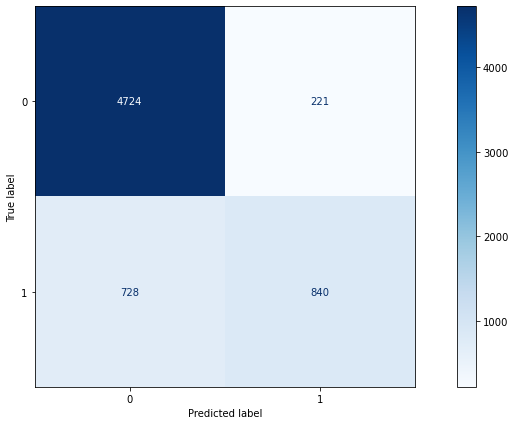

In [10]:
aux.plot_cm(model_votinghard, X_validation, y_validation)

## Soft Voting

Ahora veremos como funciona el ensamble Voting Soft

In [11]:
model_votingsoft = VotingClassifier(estimators=[('tree', model_tree), ('knn', model_knn), ('neural_network', model_neural_network)], voting='soft')

Entrenamos con el training set:

In [12]:
model_votingsoft.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_leaf=50)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=43)),
                             ('neural_network',
                              MLPClassifier(activation='tanh', alpha=0.1,
                                            hidden_layer_sizes=(20, 20),
                                            tol=1e-05))],
                 voting='soft')

Predecimos con el validation set:

In [13]:
votingsoft_predict = model_votingsoft.predict(X_validation)

**Metricas**

In [14]:
print(classification_report(y_validation, votingsoft_predict))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4945
           1       0.78      0.60      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.80      6513
weighted avg       0.86      0.86      0.86      6513



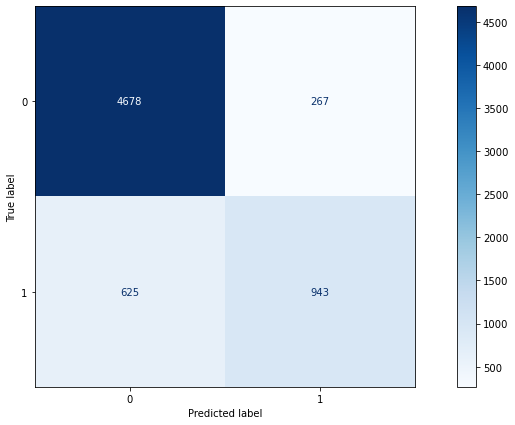

In [15]:
aux.plot_cm(model_votingsoft, X_validation, y_validation)

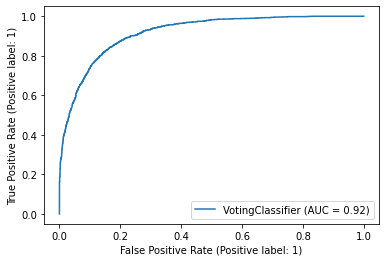

In [16]:
plot_roc_curve(model_votingsoft, X_validation, y_validation, response_method="predict_proba")
plt.show()

In [17]:
print("Mejor score AUC_ROC en validación:", roc_auc_score(y_validation, model_votingsoft.predict_proba(X_validation)[:, 1]))

Mejor score AUC_ROC en validación: 0.9174844849466581


## Preprocesado 2: Eliminación de Features + Reducción por Frecuencia + OHE + Estandarización

Para estre preprocesado primero eliminamos las columnas que consideramos que no aportan información. Luego agrupamos todas las categorias con menos del 5% de los datos en una misma. Finalmente aplicamos OHE y estandarizamos.

In [18]:
X_p2 = eliminar_features(X, ['religion', 'barrio', 'categoria_de_trabajo'])
X_p2 = reduce_by_frequency(X_p2, ['estado_marital', 'trabajo'], 0.05)

In [19]:
init_OHE(X_p2)
X_p2 = apply_OHE(X_p2)

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p2, y, random_state=0, test_size=0.2, stratify=y
)

In [21]:
X_train = standarize(X_train)
X_validation = standarize(X_validation)

In [22]:
model_voting_p2 = VotingClassifier(estimators=[('tree', model_tree), ('knn', model_knn), ('neural_network', model_neural_network)], voting='soft')

Entrenamos con el training set:

In [23]:
model_voting_p2.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_leaf=50)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_neighbors=43)),
                             ('neural_network',
                              MLPClassifier(activation='tanh', alpha=0.1,
                                            hidden_layer_sizes=(20, 20),
                                            tol=1e-05))],
                 voting='soft')

Predecimos con el validation set:

In [ ]:
voting_predict = model_voting_p2.predict(X_validation)

**Metricas**

In [ ]:
print(classification_report(y_validation, voting_predict))

In [ ]:
aux.plot_cm(model_voting_p2, X_validation, y_validation)

In [ ]:
plot_roc_curve(model_voting_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

In [ ]:
print("Mejor score AUC_ROC en validación:", roc_auc_score(y_validation, model_voting_p2.predict_proba(X_validation)[:, 1]))

# Conclusión

Vimos que utilizando modelos con similar performance de la metrica *auc_roc* como lo son Arbol, KNN o Red Neuronal obtenemos un ensamble que mejora esta métrica. Por otro lado, no podemos utilizar Voting Hard debido a que estamos buscando el mejor modelo en base a la metrica *auc_roc*.

# Predicción

Por ultimo, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [ ]:
ids, X_holdout = aux.get_holdout_set()

In [ ]:
X_holdout = init_dataset(X_holdout)

In [ ]:
init_OHE(X)
X_holdout_ohe = apply_OHE(X_holdout)

In [ ]:
votingsoft_predict = model_votingsoft.predict(X_holdout_ohe)

In [ ]:
aux.create_prediction(ids,votingsoft_predict,file_name='voting')